In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as color
from os import times

In [2]:
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [3]:
def fdtd_1d(eps_rel, dx, time_span, source_frequency, source_position,
            source_pulse_length):
    '''Computes the temporal evolution of a pulsed excitation using the
    1D FDTD method. The temporal center of the pulse is placed at a
    simulation time of 3*source_pulse_length. The origin x=0 is in the
    center of the computational domain. All quantities have to be
    specified in SI units.

    Arguments
    ---------
        eps_rel : 1d-array
            Rel. permittivity distribution within the computational domain.
        dx : float
            Spacing of the simulation grid (please ensure dx <= lambda/20).
        time_span : float
            Time span of simulation.
        source_frequency : float
            Frequency of current source.
        source_position : float
            Spatial position of current source.
        source_pulse_length :
            Temporal width of Gaussian envelope of the source.
    '''
    # Constants
    c = 2.99792458e8  # Speed of light [m/s]
    mu0 = 4 * np.pi * 1e-7  # Vacuum permeability [Vs/(Am)]
    eps0 = 1 / (mu0 * c**2)  # Vacuum permittivity [As/(Vm)]
    Z0 = np.sqrt(mu0 / eps0)  # Vacuum impedance [Ohm]

    # Geometry parameters
    x_span = 18e-6
    dt = dx / (2 * c)

    # Coordinates
    x = np.linspace(-x_span/2, x_span/2, int(round(x_span/dx)) + 1) #1201
    t = np.arange(0, time_span, dt) #2399
    
    # Source
    carrier = np.exp(-2*np.pi*1j*source_frequency*t)
    jz_spatial_distribution = np.zeros_like(x)
    jz_spatial_distribution[np.abs(x - source_position) < 1e-10] = 1
    envelope = np.exp(-((t - 3*source_pulse_length) ** 2) / (source_pulse_length ** 2))
    jz = jz_spatial_distribution * carrier[:, np.newaxis] * envelope[:, np.newaxis]

    # Field arrays
    Ez = np.zeros((len(t), len(x)))
    Hy = np.zeros((len(t), len(x)))
    
    
    
    # FDTD loop
    for n in range(1, len(t)-1):
        # Update Ez
        for j in range(1, len(x) - 1):
            Ez[n+1, j] = Ez[n, j] + np.real((dt / (dx * eps_rel[j])) * (Hy[n, j] - Hy[n, j-1])-dt/(eps0*eps_rel[j])*jz[n, j])
        # Update Hy
        for j in range(len(x) - 1):
            Hy[n+1, j]=Hy[n, j]+1/mu0*dt/dx*(Ez[n+1, j+1]-Ez[n+1, j])

    
    '''
    Returns
    -------
        Ez : 2d-array
            Z-component of E(x,t) (each row corresponds to one time step)
        Hy : 2d-array
            Y-component of H(x,t) (each row corresponds to one time step)
        x  : 1d-array
            Spatial coordinates of the field output
        t  : 1d-array
            Time of the field output
    '''
    return Ez, Hy, x, t

In [4]:
# constants
c = 2.99792458e8 # speed of light [m/s] 
mu0 = 4*np.pi*1e-7 # vacuum permeability [Vs/(Am)]
eps0 = 1/(mu0*c**2) # vacuum permittivity [As/(Vm)]
Z0 = np.sqrt(mu0/eps0) # vacuum impedance [Ohm]


# geometry parameters
x_span = 18e-6 # width of computatinal domain [m]
n1 = 1 # refractive index in front of interface
n2 = 2 # refractive index behind interface
x_interface = x_span/4 #postion of dielectric interface

# simulation parameters
dx = 15e-9 # grid spacing [m]
time_span = 60e-15 # duration of simulation [s]

Nx = int(round(x_span/dx)) + 1 # number of grid points

# source parameters
source_frequency = 500e12 # [Hz]
source_position = 0 # [m]
source_pulse_length = 1e-15 # [s]

In [5]:
eps_rel=eps0*np.ones((Nx,))

In [5]:
Ez, Hy, x, t=fdtd_1d(eps_rel, dx, time_span, source_frequency, source_position, source_pulse_length)

In [6]:
print(Ez.shape)
print(Hy.shape)
print(x.shape)
print(t.shape)

(2399, 1201)
(2399, 1201)
(1201,)
(2399,)


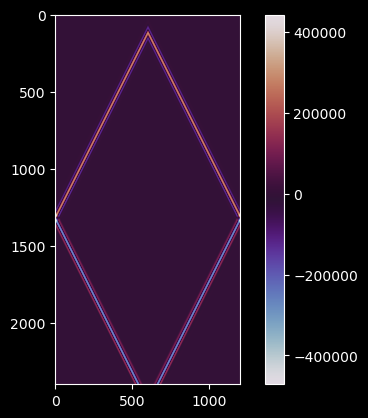

In [12]:
norm = color.Normalize(Ez.real.min(), Ez.real.max())
twilight = cm.ScalarMappable(norm=norm, cmap="twilight")
plt.imshow(Ez.real, cmap="twilight")
plt.colorbar(twilight)